<a href="https://colab.research.google.com/github/AndrewArnett/DS-Unit-2-Kaggle-Challenge/blob/master/U2_S2_M4_Assignment_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [7]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [19]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.model_selection import cross_val_score

In [13]:
import numpy as np

def wrangle(X):
  X = X.copy()
  
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  X['year_recorded'] = X['date_recorded'].dt.year
  X['year_recorded'] = X['date_recorded'].dt.month
  X['year_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  X['years'] = X['year_recorded'] - X['construction_year']

  X['years'] = X['year_recorded'] - X['construction_year']

  columns = ['quantity_group', 'num_private', 'amount_tsh', 
             'payment', 'recorded_by', 'id', 'date_recorded']
  
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  
  cols_with_zeros = ['longitude', 'latitude', 'population', 'gps_height', 'construction_year']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col] = X[col].replace(1, np.nan)

  X = X.drop(columns=columns, axis=1)

  return X

  train = wrangle(train)
  test = wrangle(test)

In [14]:
target = 'status_group'
train_features = train.drop(columns=[target, 'id'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 125].index.tolist()
features = numeric_features + categorical_features

print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'lga', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [15]:
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [20]:
model = make_pipeline(
                  (OrdinalEncoder()),
                  (SimpleImputer(strategy='mean')),
                  (RandomForestClassifier(min_samples_leaf=2, n_jobs=-1, random_state=23))
)

model.fit(X_train, y_train)

k = 5
scores = cross_val_score(model, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'accuracy of {k} folds:', scores)

accuracy of 5 folds: [0.81329966 0.81052189 0.81405724 0.80875421 0.80816498]


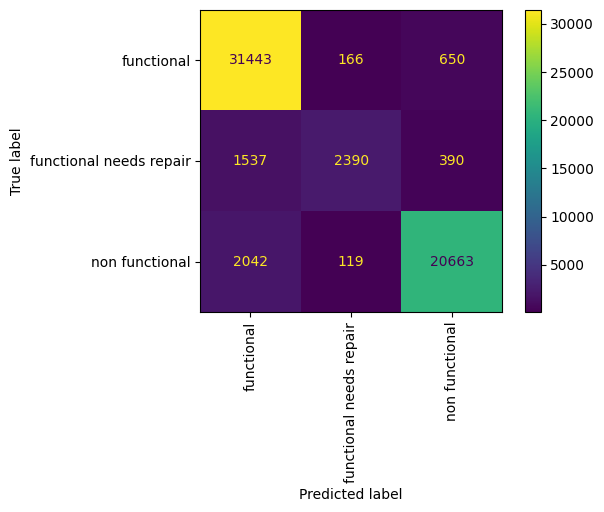

In [22]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(model, X_train, y_train, values_format='.0f', xticks_rotation='vertical')